<a href="https://colab.research.google.com/github/ashwinsapre/GANfaces_iCarl/blob/main/iCarl_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import keras.layers as L
from keras.datasets import fashion_mnist
from keras.applications import DenseNet121
from keras.applications import VGG16
import matplotlib.pyplot as plt

 For multi-task learning, branching NN out
- one branch predicts the class of FashionMNIST object (classification)
- other branch predicts whether the object is a "top" or not (0/1 output)

In [5]:
def create_model(n_classes, input_dim, cl_weight, b_weight, lr):
    '''
        Creating categorical classification model
    '''
    
    inputs=L.Input((input_dim,input_dim,1))
    
    xc=L.Conv2D(64, kernel_size=3, padding='same', strides=1)(inputs)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.Conv2D(64, kernel_size=3, padding='same', strides=1)(xc)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.MaxPool2D(pool_size=2, strides=2)(xc)
    
    xc=L.Conv2D(32, kernel_size=3, padding='same', strides=1)(inputs)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.Conv2D(32, kernel_size=3, padding='same', strides=1)(xc)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.MaxPool2D(pool_size=2, strides=2)(xc)
    
    xc=L.Conv2D(16, kernel_size=3, padding='same', strides=1)(xc)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.Conv2D(16, kernel_size=3, padding='same', strides=1)(xc)
    xc=L.LeakyReLU(0.2)(xc)
    xc=L.MaxPool2D(pool_size=2, strides=2)(xc)
    
    xc=L.Flatten()(xc)
    xc=L.Dense(n_classes)(xc)
    outputc=L.Softmax(name='outputc')(xc)
    
    '''
        Creating binary classification model (a top/not a top)
    '''
    
    x=L.LeakyReLU(0.2)(inputs)
    x=L.Conv2D(32, kernel_size=3, padding='same', strides=1)(x)
    x=L.LeakyReLU(0.2)(x)
    x=L.MaxPool2D(pool_size=2, strides=2)(x)
    
    x=L.Conv2D(16, kernel_size=3, padding='same', strides=1)(x)
    x=L.LeakyReLU(0.2)(x)
    x=L.Conv2D(16, kernel_size=3, padding='same', strides=1)(x)
    x=L.LeakyReLU(0.2)(x)
    x=L.MaxPool2D(pool_size=2, strides=2)(x)
    
    x=L.Flatten()(x)
    outputb=L.Dense(1, activation='sigmoid', name='outputb')(x)
    #outputb=L.Activation('sigmoid', name="outputb")(x)

    '''
        Combining both models
    '''
    model=keras.Model(inputs=inputs, outputs=[outputc, outputb])
    losses={'outputc':'categorical_crossentropy', 'outputb':'binary_crossentropy'}
    loss_weights=[cl_weight, b_weight]
    model.compile(optimizer=keras.optimizers.Adam(lr), 
                      loss=losses,
                      loss_weights=loss_weights,
                      metrics=['accuracy'])
    
    return model

In [6]:
def train_model(model, n_epochs:int, x_train, y_trainc, y_trainb, validation_split):
    history=model.fit(x=x_train, 
                      y={'outputc':y_trainc, 'outputb': y_trainb}, 
                      epochs=n_epochs, 
                      validation_split=0.1,
                      shuffle=True)
    return model

In [36]:
def calc_feature_vector(model, images, labels):
    #extract feature vector from a layer of ALREADY-TRAINED model
    #size of feature vector=784
    feature_model=keras.Model(inputs=model.inputs, outputs=model.get_layer("flatten").output)
    feature_vectors=[]
    for i in range(len(images)):
      x=feature_model.predict(images)[i]
      x=x/np.linalg.norm(x)
      feature_vectors.append(x)
    return np.asarray(feature_vectors)

In [8]:
def create_exemplar_set(mem_size, n_classes, feature_vectors, labels):
    #'images' has images all of class=y
    per_class=mem_size/n_classes
    
    chosen_exemplars=exemplars[:size]
    mean_exemplar=sum(exemplars)/len(images)
    return chosen_exemplars, mean_exemplar

In [9]:
def classify(X, mean_exemplar_sets):    
    image_vector=calc_feature_vector(X)
    #exemplar set closest to X feature map is chosen
    return None

In [10]:
def transform_outputs(y_train, y_test):
    labeldict={}
    labeldict[0]=1
    labeldict[1]=0
    labeldict[2]=1
    labeldict[3]=1
    labeldict[4]=1
    labeldict[5]=0
    labeldict[6]=1
    labeldict[7]=0
    labeldict[8]=0
    labeldict[9]=0
    
    y_trainb=[]
    y_testb=[]
    y_trainc=keras.utils.to_categorical(y_train)
    y_testc=keras.utils.to_categorical(y_test)
    
    for i in range(len(y_train)):
        y_trainb.append(labeldict[y_train[i]])
        
    for i in range(len(y_test)):
        y_testb.append(labeldict[y_test[i]])
    
    return y_trainc, y_testc, np.asarray(y_trainb), np.asarray(y_testb)

In [11]:

(x_train, y_train), (x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
x_train=x_train.reshape((x_train.shape[0], 28,28,1))
x_test=x_test.reshape((x_test.shape[0],28,28,1))
y_trainc, y_testc, y_trainb, y_testb=transform_outputs(y_train, y_test)
x_train=x_train/255.0
x_test=x_test/255.0

#np.savetxt("ytrain_transformed.csv", y_train, delimiter=',')
#np.savetxt("ytest_transformed.csv", y_test, delimiter=',')
    
#y_train=np.loadtxt(open("ytrain_transformed.csv", "rb"), delimiter=',')
#y_test=np.loadtxt(open("ytest_transformed.csv", "rb"), delimiter=',')
    
model=create_model(n_classes=10, input_dim=28, cl_weight=1.0, b_weight=1.5, lr=0.0005)
    
train_model(model, 50, x_train, y_trainc, y_trainb, validation_split=0.1)
model.save("trainedmodel.h5")
#-----------------------------------------------------------------------#

4423680/4422102 [==============================] - 0s 0us/step
Epoch 1/50
1688/1688 [==============================] - 19s 7ms/step - loss: 0.9976 - outputc_loss: 0.7522 - outputb_loss: 0.1636 - outputc_accuracy: 0.7302 - outputb_accuracy: 0.9421 - val_loss: 0.4646 - val_outputc_loss: 0.3945 - val_outputb_loss: 0.0468 - val_outputc_accuracy: 0.8557 - val_outputb_accuracy: 0.9850
Epoch 2/50
1688/1688 [==============================] - 10s 6ms/step - loss: 0.4194 - outputc_loss: 0.3532 - outputb_loss: 0.0441 - outputc_accuracy: 0.8749 - outputb_accuracy: 0.9871 - val_loss: 0.3786 - val_outputc_loss: 0.3258 - val_outputb_loss: 0.0352 - val_outputc_accuracy: 0.8818 - val_outputb_accuracy: 0.9890
Epoch 3/50
1688/1688 [==============================] - 11s 6ms/step - loss: 0.3589 - outputc_loss: 0.3075 - outputb_loss: 0.0342 - outputc_accuracy: 0.8906 - outputb_accuracy: 0.9901 - val_loss: 0.3366 - val_outputc_loss: 0.2868 - val_outputb_loss: 0.0332 - val_outputc_accuracy: 0.8958 - val_outpu

In [12]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
model.save("trainedmodel", "/content/gdrive/MyDrive/iCarlModel")

INFO:tensorflow:Assets written to: trainedmodel/assets


In [ ]:
#mmodel=keras.models.load_model("trainedmodel")

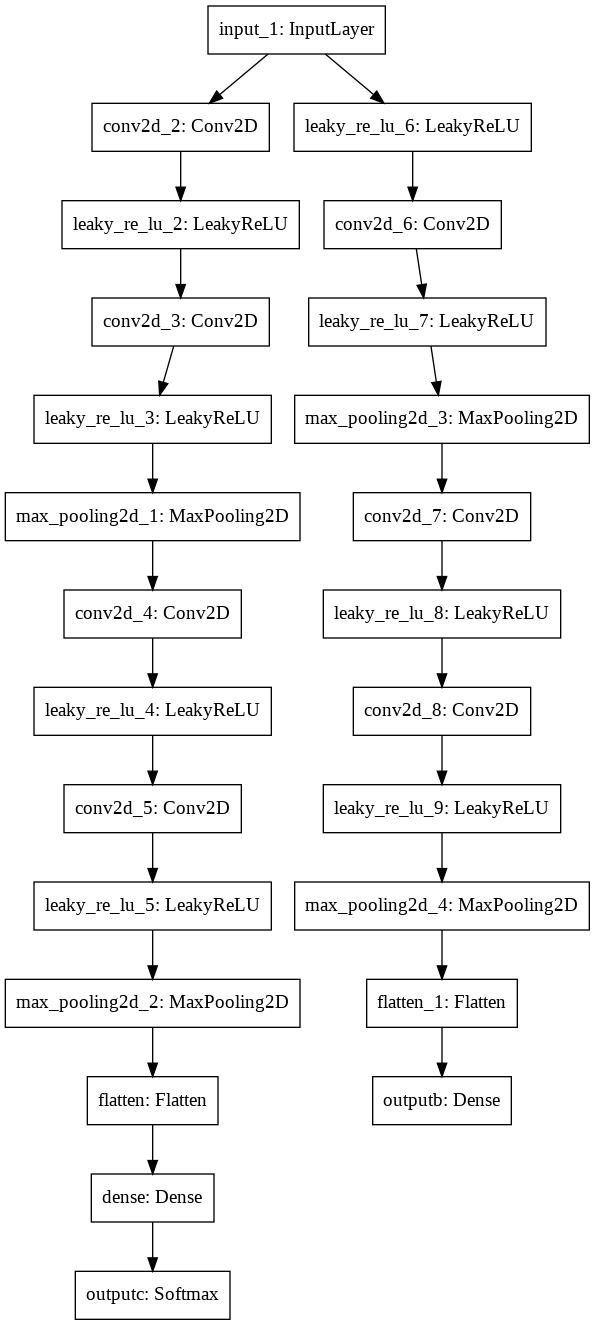

In [14]:
tf.keras.utils.plot_model(model)

In [15]:
feature_model=keras.Model(inputs=model.inputs, outputs=model.get_layer("flatten").output)

In [35]:
feature_vectors=[]
for i in range(1000):
  x=feature_model.predict(x_test)[i]
  x=x/np.linalg.norm(x)
  feature_vectors.append(x)
return feature_vectors

(1, 784)
(2, 784)
(3, 784)
(4, 784)
(5, 784)
(6, 784)
(7, 784)
(8, 784)
(9, 784)
(10, 784)
(11, 784)
(12, 784)
(13, 784)
(14, 784)
(15, 784)
(16, 784)
(17, 784)
(18, 784)
(19, 784)
(20, 784)


KeyboardInterrupt: ignored